# Cement compressive strength prediction problem

# Setup

In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

# Step 1a: Load data

In [2]:
data = pd.read_excel("./dataset/uci_data/Concrete_Data.xls")
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

There is no missing value in the data.

In [4]:
# Rename the columns
ori_col_names = data.columns
ori_col_names

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')

In [5]:
new_col_names = []
for col_name in data.columns.values:
    new_col_names.append(col_name.split("(")[0])
    
new_col_names

['Cement ',
 'Blast Furnace Slag ',
 'Fly Ash ',
 'Water  ',
 'Superplasticizer ',
 'Coarse Aggregate  ',
 'Fine Aggregate ',
 'Age ',
 'Concrete compressive strength']

In [6]:
data.columns = new_col_names
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


# Step 1b: Partition the data

In [7]:
N = data.shape[0]

# numpy rng object
rng = np.random.default_rng(2000)
shuffle_idx = rng.permutation(N)
train_idx = shuffle_idx[:850]
test_idx = shuffle_idx[850:]

train_data = data.iloc[train_idx,:]
test_data = data.iloc[test_idx, :]

# Step 2: Exploratory data analysis

## Statistical metrics calculation

In [8]:
train_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,280.341035,75.147765,54.530953,181.677094,6.179245,971.989353,773.675812,45.244706,35.636721
std,105.257532,87.206529,64.050418,21.274296,5.908486,77.413030,79.728726,62.650893,16.730468
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,190.680000,0.000000,0.000000,164.900000,0.000000,932.000000,734.000000,7.000000,23.740038
50%,266.000000,22.000000,0.000000,185.000000,6.470000,968.000000,779.320000,28.000000,33.945317
75%,353.750000,144.925000,118.270000,192.940000,10.160000,1028.400000,823.550000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,81.751169


In [9]:
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

## Data visualization
- histogram
- scatter plot matrix
- correlogram

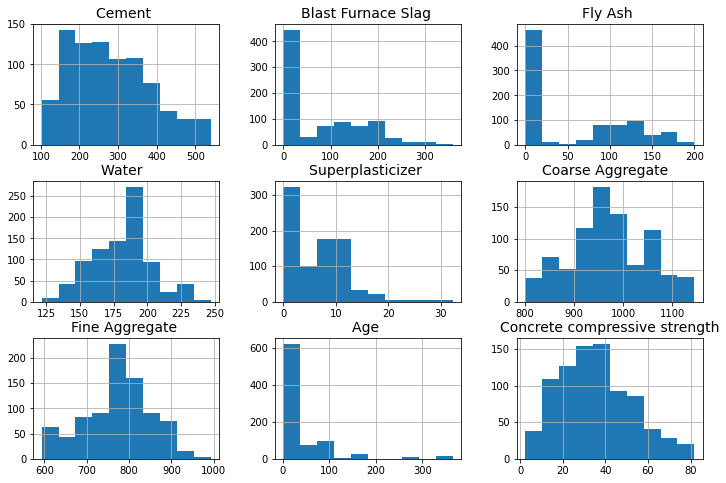

In [14]:
train_data.hist(bins=10, figsize=(12, 8))
plt.show()

In [15]:
# Let examine the skewness of each numerical attribute
from scipy.stats import skew

skew(train_data.to_numpy())

array([ 0.50700228,  0.78987256,  0.52250582,  0.06266267,  0.89423052,
       -0.03724532, -0.23448853,  3.23345247,  0.41842266])

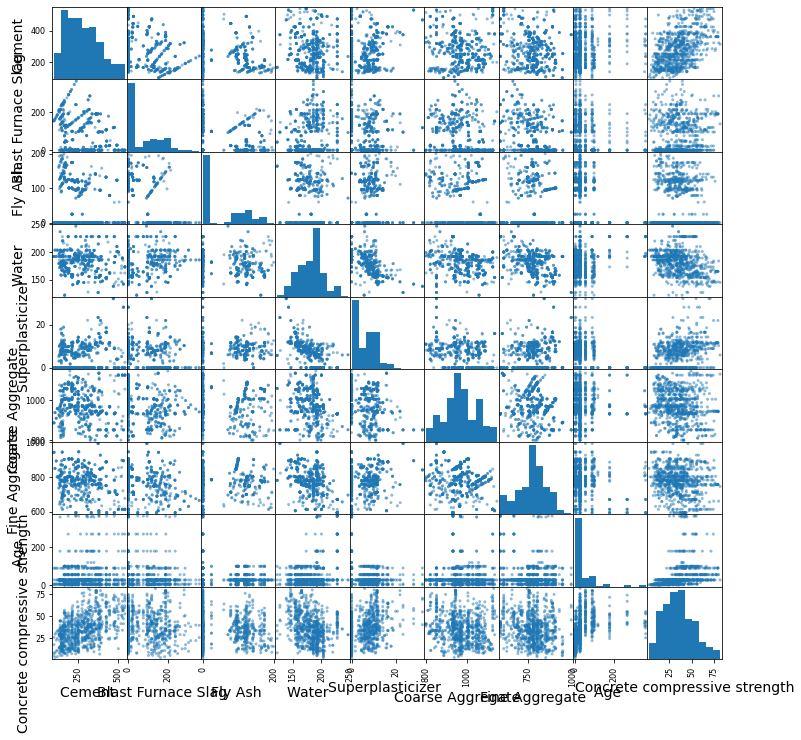

In [17]:
# scatter plot matrix
from pandas.plotting import scatter_matrix

scatter_matrix(train_data, figsize=(12, 12))
plt.show()

In [18]:
# Correlogram
train_data.corr()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
Cement,1.000000,-0.292982,-0.382880,-0.091472,0.084893,-0.118666,-0.200507,0.103254,0.499420
Blast Furnace Slag,-0.292982,1.000000,-0.328180,0.120856,0.032861,-0.272715,-0.287585,-0.070997,0.110174
Fly Ash,-0.382880,-0.328180,1.000000,-0.256539,0.383662,0.002873,0.064912,-0.154963,-0.094198
Water,-0.091472,0.120856,-0.256539,1.000000,-0.654446,-0.199006,-0.443352,0.266778,-0.295408
Superplasticizer,0.084893,0.032861,0.383662,-0.654446,1.000000,-0.253236,0.219129,-0.198255,0.354244
Coarse Aggregate,-0.118666,-0.272715,0.002873,-0.199006,-0.253236,1.000000,-0.181122,0.015281,-0.157345
Fine Aggregate,-0.200507,-0.287585,0.064912,-0.443352,0.219129,-0.181122,1.000000,-0.157243,-0.159049
Age,0.103254,-0.070997,-0.154963,0.266778,-0.198255,0.015281,-0.157243,1.000000,0.335469
Concrete compressive strength,0.499420,0.110174,-0.094198,-0.295408,0.354244,-0.157345,-0.159049,0.335469,1.000000


Text(0.5, 1.0, 'Correlation heatmap')

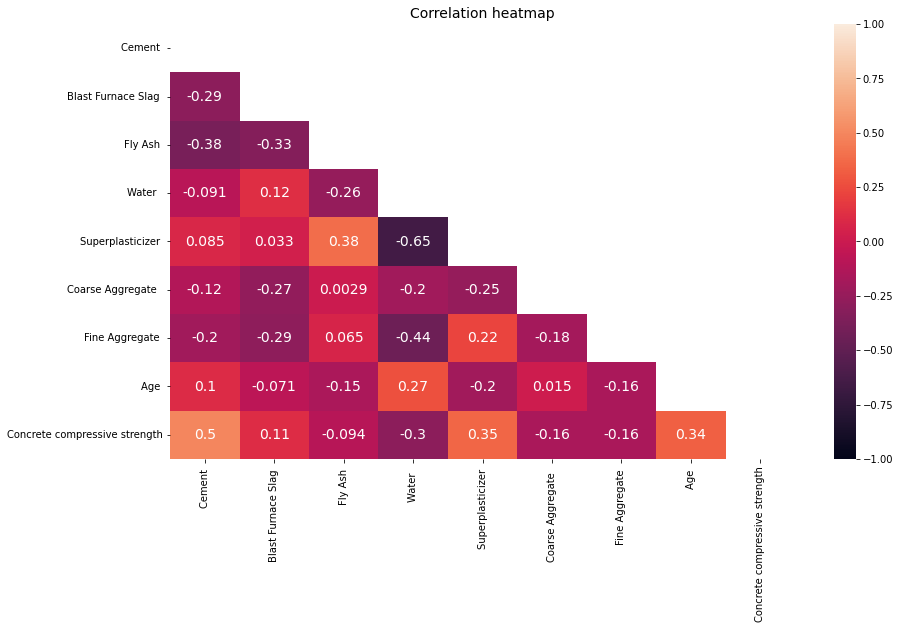

In [20]:
import seaborn as sns

plt.figure(figsize=(14, 8))
mask = np.triu(np.ones_like(train_data.corr(), dtype=bool))
heatmap = sns.heatmap(train_data.corr(), mask = mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Correlation heatmap")

# Step 4: Log transform + linear regression (pipeline)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression

def log_transform(x):
    return np.log(x+1)

log_trans = FunctionTransformer(log_transform)

lin_reg = make_pipeline(log_trans,
                       LinearRegression())

In [22]:
# Training
lin_reg.fit(X_train, y_train)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function log_transform at 0x000002614C308AF0>)),
                ('linearregression', LinearRegression())])

# step 5: Evaluation

In [23]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(y_test, lin_reg.predict(X_test), squared=False)
lin_rmse

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


7.609475507637928

---

# Extra regression models

## ridge regression

In [24]:
from sklearn.linear_model import RidgeCV

range_val_alpha = [0.01, 0.1, 1.0, 10, 100]
ridge_lr = RidgeCV(range_val_alpha, cv=5)
ridge_lr.fit(X_train, y_train)
ridge_lr.alpha_

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_spar

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_spar

100.0

In [25]:
lin_rmse_ridge = mean_squared_error(y_test, ridge_lr.predict(X_test), squared=False)
lin_rmse_ridge

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


10.094966341483627

## Random forest regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_features=3,
    oob_score=True,
    n_jobs=-1,
    random_state=20
)

rf_reg.fit(X_train, y_train)
rf_reg.oob_score_

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.9145416503056706

In [27]:
rf_rmse = mean_squared_error(y_test, rf_reg.predict(X_test), squared=False)
rf_rmse

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


5.174498209781251